In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [12]:
data = pd.read_csv('TSLA.csv')
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-06-29,3.800,5.000,3.508,4.778,4.778,93831500
1,2010-06-30,5.158,6.084,4.660,4.766,4.766,85935500
2,2010-07-01,5.000,5.184,4.054,4.392,4.392,41094000
3,2010-07-02,4.600,4.620,3.742,3.840,3.840,25699000
4,2010-07-06,4.000,4.000,3.166,3.222,3.222,34334500


In [16]:
data = data[['Date', 'Open']]  # Keep only the required columns
data.rename(columns={'Open': 'price'}, inplace=True)  # Rename for consistency
data['returns'] = data['price'].pct_change().fillna(0)  # Calculate percentage change

# Print the processed dataset for verification
print(data.head())


         Date  price   returns
0  2010-06-29  3.800  0.000000
1  2010-06-30  5.158  0.357368
2  2010-07-01  5.000 -0.030632
3  2010-07-02  4.600 -0.080000
4  2010-07-06  4.000 -0.130435


In [17]:
# Define the environment
class PortfolioManagementEnv:
    def __init__(self, data, initial_balance=1000):
        self.data = data.reset_index(drop=True)
        self.initial_balance = initial_balance
        self.balance = initial_balance
        self.position = 0
        self.current_step = 0
        self.state_size = 2  # [current price, position]
        self.done = False

    def reset(self):
        self.balance = self.initial_balance
        self.position = 0
        self.current_step = 0
        self.done = False
        return self._get_state()

    def _get_state(self):
        return [self.data.iloc[self.current_step]['price'], self.position]

    def step(self, action):
        """
        Actions: 0 = Hold, 1 = Buy, 2 = Sell
        """
        if self.done:
            raise Exception("Episode has ended. Please reset the environment.")

        price = self.data.iloc[self.current_step]['price']
        reward = 0

        if action == 1:  # Buy
            self.position += 1
            self.balance -= price
        elif action == 2:  # Sell
            if self.position > 0:
                self.position -= 1
                self.balance += price

        self.current_step += 1
        if self.current_step >= len(self.data) - 1:
            self.done = True

        portfolio_value = self.balance + (self.position * price)
        reward = portfolio_value - self.initial_balance

        return self._get_state(), reward, self.done

In [18]:

# Define the Q-Learning Agent
class QLearningAgent:
    def __init__(self, state_size, action_size, learning_rate=0.1, discount_factor=0.95, epsilon=1.0, epsilon_decay=0.995):
        self.state_size = state_size
        self.action_size = action_size
        self.q_table = {}
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay

    def get_state_key(self, state):
        return tuple(np.round(state, 2))

    def get_action(self, state):
        if np.random.rand() < self.epsilon:
            return np.random.choice(range(self.action_size))
        state_key = self.get_state_key(state)
        if state_key not in self.q_table:
            self.q_table[state_key] = np.zeros(self.action_size)
        return np.argmax(self.q_table[state_key])

    def update_q_table(self, state, action, reward, next_state, done):
        state_key = self.get_state_key(state)
        next_state_key = self.get_state_key(next_state)
        if state_key not in self.q_table:
            self.q_table[state_key] = np.zeros(self.action_size)
        if next_state_key not in self.q_table:
            self.q_table[next_state_key] = np.zeros(self.action_size)

        q_update = reward
        if not done:
            q_update += self.discount_factor * np.max(self.q_table[next_state_key])
        self.q_table[state_key][action] += self.learning_rate * (q_update - self.q_table[state_key][action])

    def decay_epsilon(self):
        self.epsilon *= self.epsilon_decay

In [19]:
import matplotlib.pyplot as plt

# Initialize lists to store rewards for visualization
episode_rewards = []

# Training the Q-Learning Agent
env = PortfolioManagementEnv(data)
agent = QLearningAgent(state_size=env.state_size, action_size=3)  # Actions: Hold, Buy, Sell

episodes = 500
for episode in range(episodes):
    state = env.reset()
    total_reward = 0
    while True:
        action = agent.get_action(state)
        next_state, reward, done = env.step(action)
        agent.update_q_table(state, action, reward, next_state, done)
        state = next_state
        total_reward += reward
        if done:
            break
    agent.decay_epsilon()
    episode_rewards.append(total_reward)
    print(f"Episode {episode + 1}/{episodes}, Total Reward: {total_reward:.2f}")




Episode 1/500, Total Reward: 2163326.40
Episode 2/500, Total Reward: 16934751.47
Episode 3/500, Total Reward: 17042335.57
Episode 4/500, Total Reward: 22259329.00
Episode 5/500, Total Reward: 1443512.85
Episode 6/500, Total Reward: 13446052.62
Episode 7/500, Total Reward: 25295586.32
Episode 8/500, Total Reward: 9468727.66
Episode 9/500, Total Reward: 10286416.81
Episode 10/500, Total Reward: 27303573.53
Episode 11/500, Total Reward: 11791265.24
Episode 12/500, Total Reward: 11765467.46
Episode 13/500, Total Reward: 8873444.90
Episode 14/500, Total Reward: 6332020.86
Episode 15/500, Total Reward: 2337613.67
Episode 16/500, Total Reward: 5998556.68
Episode 17/500, Total Reward: 6757066.53
Episode 18/500, Total Reward: 19713599.43
Episode 19/500, Total Reward: 8421844.01
Episode 20/500, Total Reward: 5106204.96
Episode 21/500, Total Reward: 17690554.57
Episode 22/500, Total Reward: 13649276.01
Episode 23/500, Total Reward: 4707903.90
Episode 24/500, Total Reward: 10405242.76
Episode 25/5

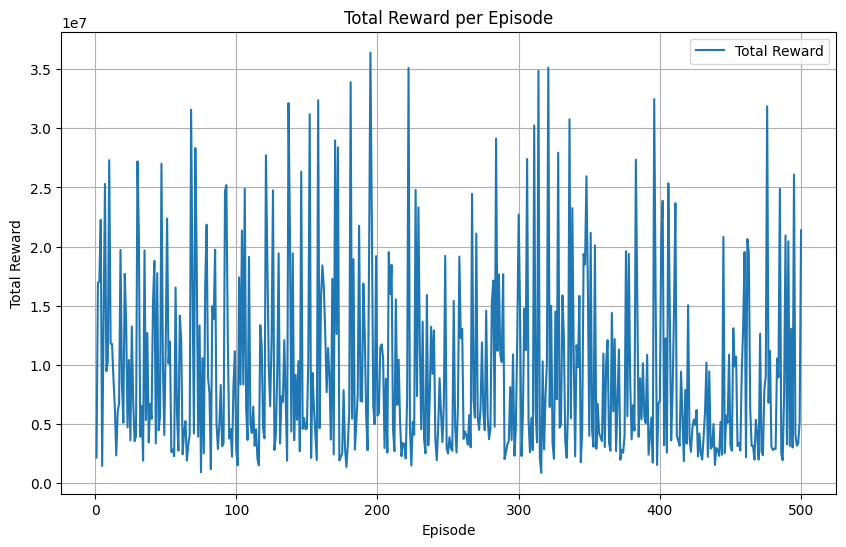

In [20]:
# Plot the rewards over episodes
plt.figure(figsize=(10, 6))
plt.plot(range(1, episodes + 1), episode_rewards, label='Total Reward')
plt.title('Total Reward per Episode')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.legend()
plt.grid()
plt.show()

In [21]:
import pickle

# Save the Q-learning agent's Q-table to a file
with open("q_learning_agent.pkl", "wb") as f:
    pickle.dump(agent.q_table, f)

print("Model saved successfully.")


Model saved successfully.


In [ ]:
state = env.reset()
total_reward = 0
while True:
    action = np.argmax(agent.q_table.get(agent.get_state_key(state), np.zeros(3)))
    state, reward, done = env.step(action)
    total_reward += reward
    if done:
        break
print(f"Test Total Reward: {total_reward:.2f}")